In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from collections import Counter
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('train.csv', header=0, sep=",")
# print data frame dimensions
print df.shape

# print some rows
df.head()
#df.OutcomeType.value_counts()
df.AgeuponOutcome.value_counts()

df.head()

(26729, 10)


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [3]:
# check for unassigned names
print df["Name"].isnull().value_counts()

# convert names to binary has_name
has_name = (~df.loc[:,"Name"].isnull()).apply(lambda x: int(x))

# check animal types
df["AnimalType"].value_counts()
# convert Animal Type categorical variable to binary (1 if dog; 0 if cat)
is_dog = df["AnimalType"].apply(lambda x: float(x=="Dog"))
is_dog  = is_dog.astype('category')
#pd.DataFrame({'has_name':has_name, 'name':df["Name"]}).head()

# add has_name and is_dog to data frame
df["has_name"] = has_name.astype('category')
# add is_dog column to data frame
df = df.assign(is_dog = is_dog)

False    19038
True      7691
Name: Name, dtype: int64


In [4]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,has_name,is_dog
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1,1
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1,0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,1,1
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,0,0
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,0,1


In [22]:
############ MISSING VALUES #######################
# Fins columns which have missing values
df.columns[df.isnull().any()]


Index([u'Name', u'OutcomeSubtype'], dtype='object')

In [6]:
print df["SexuponOutcome"].value_counts()

# replace missing value with "Unknown"
df["SexuponOutcome"] = np.where(df["SexuponOutcome"].isnull(), 'Unknown', df["SexuponOutcome"])

# function to translate gender into 
def get_gender(_input):
    if 'Female' in _input:
        return 'F'
    elif 'Male' in _input:
        return 'M'
    else:
        return 'U'

def get_operated(_input):    
    return float(_input.split()[0] in ['Neutered', 'Spayed'])        
    
is_operated = df["SexuponOutcome"].apply(get_operated)
is_operated.astype('category')

gender = df["SexuponOutcome"].apply(get_gender)
#gender = is_gender.astype('category')

# add is_operated, gender to df
df["is_operated"] = is_operated.astype('category')
df["gender"] = gender.astype('category')

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
Name: SexuponOutcome, dtype: int64


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


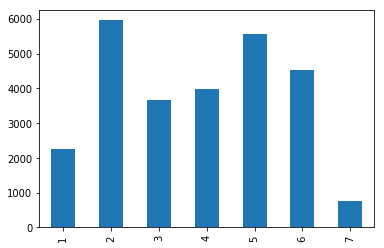

1    2248
2    5955
3    3665
4    3969
5    5565
6    4534
7     753
Name: AgeuponOutcome, dtype: int64


2    5955
5    5565
6    4534
4    3969
3    3665
1    2248
7     753
dtype: int64

In [7]:
# remove null ages
df = df[~df['AgeuponOutcome'].isnull()]
#print df['AgeuponOutcome'].value_counts()
# remove 0 years
df = df[~(df["AgeuponOutcome"] == '0 years')]

# function that normalises age of animal in years
def get_age_in_years(_input):
    age = 0.0
    age_list = _input.split()
    if "year" in age_list[1]:
        age = float(age_list[0])
    elif "month" in age_list[1]:
        age = float(age_list[0]) / 12.0
    elif "week" in age_list[1]:
        age = float(age_list[0]) / 52.0
    else:
        # if less than 1 week, default to 1 week
        age = 1.0 / 52.0
    return round(age, 3)

# Transform ages to categoris as follows:
# 1 = neonatal; 2 = infant; 3 = child; 4 = adolescent; 5 = young_adult; 6 = mature_adult; 7 = old
# These categories are based on rate that animal ages w.r.t. human years and the stages of human development
# https://www.ajdesigner.com/fl_cat_age/cat_age.php; https://pets.webmd.com/dogs/how-to-calculate-your-dogs-age
def get_age_in_labels(_input):
    age_label = 0
    age_list = _input.split()
    age = int(age_list[0])
    if "year" in age_list[1]:
        # 
        options = [4, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7]
        age = age - 1 if age < 11 else 10
        age_label = options[age]        
    elif "month" in age_list[1]:
        options = [2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3]
        age_label = options[age-1]
    elif "week" in age_list[1]:        
        age_label = 1
    else:
        # if less than 1 week, default to 1 week
        age_label = 1
    return age_label


age_in_labels = df["AgeuponOutcome"].apply(get_age_in_labels)
#fig, ax = plt.subplots()
#ax.set_xscale('log', basex=2)
age_in_labels.value_counts().sort_index(0).plot(kind='bar')

plt.show()

print age_in_labels.value_counts().sort_index(0)
age_in_labels = age_in_labels.astype('category')

# to consider keeping age_in_labels as an integer since category is ordinal
age_in_labels.value_counts()

In [8]:
# add age_in_labels to df
df["age_label"] = age_in_labels.astype('category')
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,has_name,is_dog,is_operated,gender,age_label
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1,1,1,M,4
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1,0,1,F,4
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,1,1,1,M,5
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,0,0,0,M,1
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,0,1,1,M,5


In [9]:
# apply Etienne's idea of using multinomial NBC to determinedog groups

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# import dog group training set
dog_group_train = pd.read_csv('dog_group.csv', header=None, sep="\t", names=['breed','group'])
# print first few dogs
#print dog_group_train.head()

# initialise count vectoriser
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(dog_group_train["breed"])

print X_train_counts.shape
# replace slash with space so that breed can be tokenised
clean_breed = df[df["AnimalType" ]== "Dog"]["Breed"].apply(lambda x: x.replace("/", " "))

# fit Naive Bayes to our dog group training set
mnb_classifier = MultinomialNB().fit(X_train_counts, dog_group_train["group"])


(220, 265)


In [10]:
# create word vector of clean breed
test_vect = count_vect.transform(clean_breed)
# predict dog group
group_predict =  mnb_classifier.predict(test_vect)
group_df = pd.DataFrame({'clean_breed':clean_breed, 'breed_group':group_predict})

# concatenate group dataframe to our main data frame
df = pd.concat( [df, group_df], axis=1)


In [11]:
# for cats, group is either domestic or fancy based on whether the term "domestic" appears in label
df.loc[df.is_dog == 0, 'breed_group'] = (df.loc[df.is_dog == 0, "Breed"]).apply(lambda x: "Moggie" if "Domestic" in x else "Fancy")

# for cats, clean breed by replacing slash with space 
df.loc[df.is_dog == 0, 'clean_breed'] = df.loc[df.is_dog == 0, "Breed"].apply(lambda x: x.replace("/", " "))

In [12]:
#df.clean_breed

In [13]:
df["breed_group"].value_counts()

Moggie      10370
Terrier      3884
Gundog       2856
Pastoral     2606
Toy          2496
Hound        1684
Utility      1086
Working       975
Fancy         732
Name: breed_group, dtype: int64

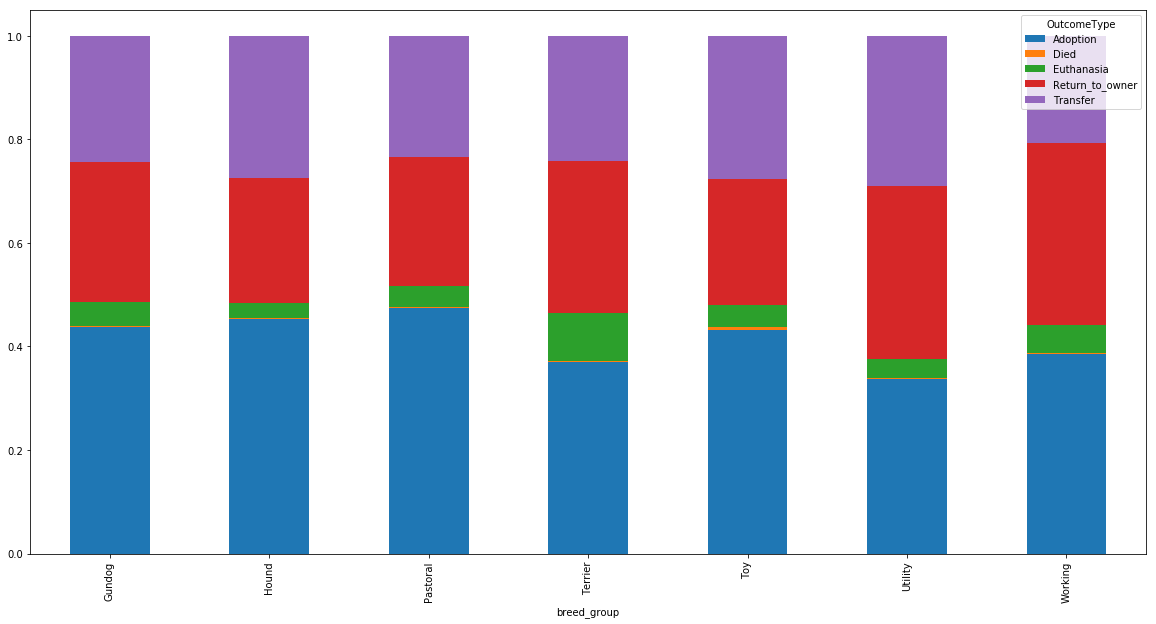

In [14]:
df.head()

df_dog = df[df["AnimalType"] == "Dog"]
group_outcome_df = pd.crosstab(df_dog.breed_group, df_dog.OutcomeType,margins=False)

# plot grouped bar chart of dog group by outcome
group_outcome_df.div(group_outcome_df.sum(1).astype(float), axis= 0).plot(kind='bar', stacked=True, figsize=(20,10))

#group_outcome_df.iloc[0:7,0:5].plot(kind='bar', figsize=(20,10))
plt.show()



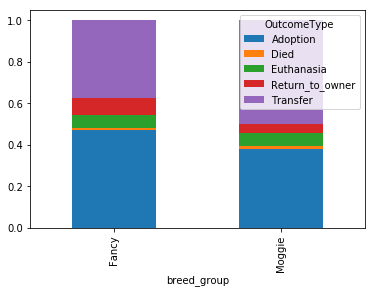

In [15]:
# plot outcome type by cat group
df_cat = df[df["AnimalType"] == "Cat"]
cat_outcome_df = pd.crosstab(df_cat.breed_group, df_cat.OutcomeType, margins=False)

# plot grouped bar chart of dog group by outcome
cat_outcome_df.div(cat_outcome_df.sum(1).astype(float), axis= 0).plot(kind='bar', stacked=True)

#group_outcome_df.iloc[0:7,0:5].plot(kind='bar', figsize=(20,10))
plt.show()


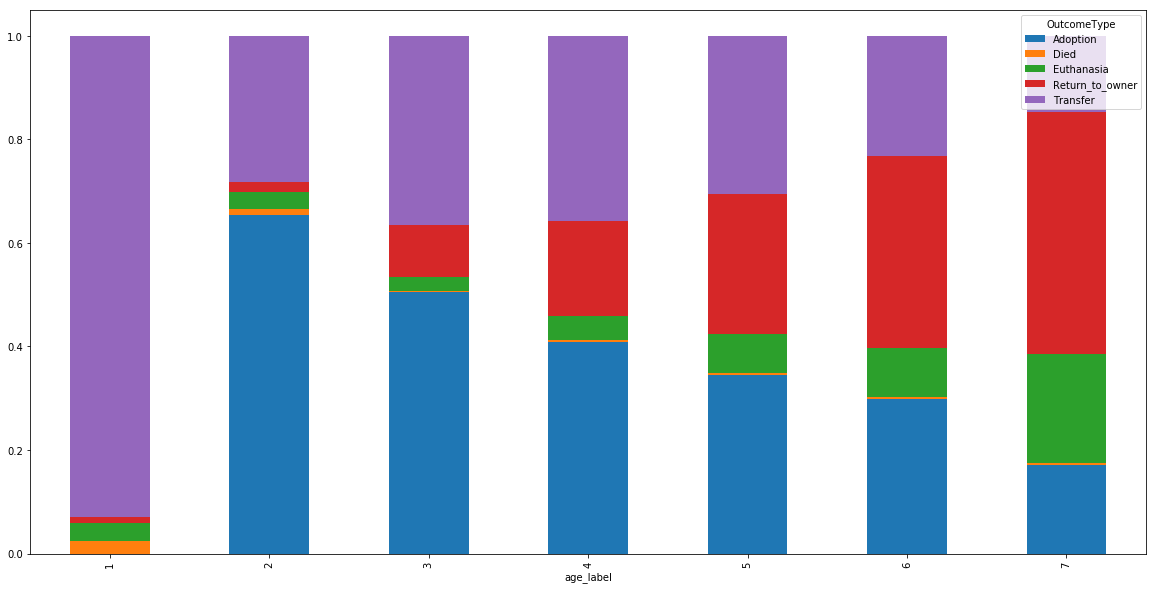

In [16]:
# plot grouped bar chart of outcome and age label
age_outcome_df = pd.crosstab(df.age_label, df.OutcomeType, margins=False)
#age_outcome_df.iloc[0:7,0:5].plot(kind='bar', figsize=(20,10))
#plt.show()

age_outcome_df.div(age_outcome_df.sum(1).astype(float), axis= 0).plot(kind='bar', stacked=True, figsize=(20,10))

#group_outcome_df.iloc[0:7,0:5].plot(kind='bar', figsize=(20,10))
plt.show()

In [17]:
#df[df["is_dog"] == 1]
# this function returns purity category: "pure", "mixed", "cross"
# depending on whether 
def get_breed_purity(_input):
    breed_purity = ""
    if "/" in _input:
        breed_purity = "cross"
    elif "Mix" in _input:
        breed_purity = "mix"
    else:
        breed_purity = "pure"
    return breed_purity

df["breed_purity"] = df["Breed"].apply(get_breed_purity).astype('category')

In [18]:
# basic utilities to find column details
cols = df.columns
print cols
df.describe()

num_cols = df._get_numeric_data().columns
# non numeric columns
list(set(cols) - set(num_cols))


Index([u'AnimalID', u'Name', u'DateTime', u'OutcomeType', u'OutcomeSubtype',
       u'AnimalType', u'SexuponOutcome', u'AgeuponOutcome', u'Breed', u'Color',
       u'has_name', u'is_dog', u'is_operated', u'gender', u'age_label',
       u'breed_group', u'clean_breed', u'breed_purity'],
      dtype='object')


['AgeuponOutcome',
 'AnimalType',
 'Breed',
 'Name',
 'AnimalID',
 'Color',
 'gender',
 'has_name',
 'clean_breed',
 'DateTime',
 'is_operated',
 'is_dog',
 'breed_purity',
 'age_label',
 'breed_group',
 'OutcomeSubtype',
 'SexuponOutcome',
 'OutcomeType']

In [164]:
# extract dog feature / can be also used with color

#docs = ['German Shepherd Mix', 'American Pit Bull Terrier Mix', 
 #       'Chihuahua Shorthair Mix','Chihuahua Shorthair Mix', 'Pit Bull Mix', 'Yorkshire Terrier Mix', 'Rat Terrier']
clean_breed_vectoriser = CountVectorizer()
dog_breed_wc = clean_breed_vectoriser.fit_transform(df.loc[is_dog==1,'clean_breed'])
df_dog_word_freq = pd.DataFrame(dog_breed_wc.toarray(), columns=clean_breed_vectoriser.get_feature_names())

#print(df_breed_word_freq)
#print df_breed_word_freq.shape

def get_breed_popularity_metric(_breed_string):
    result = float(1.0)
    _breed_string = _breed_string.lower()
    animal_count = df_dog_word_freq.shape[0]
    #print "Animal Count %d" % animal_count
    
    for x in _breed_string.split():
        if x in df_dog_word_freq.columns:            
            #print float(sum(df_dog_word_freq[x]) + 1.0) / animal_count
            result = result * (float(sum(df_dog_word_freq[x]) + 1.0) / animal_count)
        else: # we're encountering a breed term not found in our vocub
            result = result * (1.0 / animal_count)
    
    # weight on inverse term count so that longer terms get favourable weighted
    #print len(_breed_string.split())    
    return result * math.log(len(_breed_string.split())+1)
        

In [176]:
bar = get_breed_popularity_metric("Affenpinscher Mix")
print bar 
#print df_dog_word_freq.shape
#sum(df_dog_word_freq.chihuahua)


0.000569232799021


In [174]:
# apply popularity metric to dogs
# comment below line since it takes some time to calculate frequency per breed term
#dog_popularity_idx = df.loc[is_dog==1, "clean_breed"].apply(get_breed_popularity_metric)
dog_popularity_idx.head()
#df.head()

0    9.187225e-06
2    2.455212e-02
4    6.984787e-08
5    5.051701e-05
8    8.330452e-05
Name: clean_breed, dtype: float64

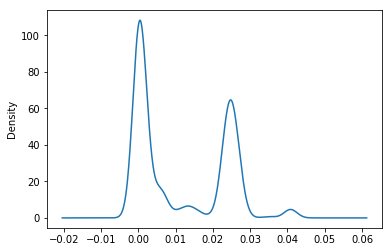

In [169]:
# not interesting - ignore
dog_popularity_idx.plot.kde()
plt.show()

In [224]:
# create two new features from date
df.head()
# check that month is returned correctly
from datetime import date, datetime

# code to determine season from: https://stackoverflow.com/a/28688724
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

print(get_season(date.today()))

print set(pd.to_datetime(df.iloc[:,2]).apply(get_season))
print set(pd.to_datetime(df.iloc[:,2]).apply(lambda x: "weekend" if x.weekday() in [5,6] else "weekday"))

pd.to_datetime(df.iloc[:,2]).apply(lambda x: "weekend" if x.weekday() in [5,6] else "weekday").value_counts()
pd.to_datetime(df.iloc[:,2]).apply(get_season).value_counts()

#import datetime
#datetime.datetime.today().weekday()
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
#print le.fit_transform(["cat", "dog", "mouse", "mouse", "dog", "cat"])
# add columns to our data frame
df["is_weekend"] = pd.to_datetime(df.iloc[:,2]).apply(lambda x: int(1  if x.weekday() in [5,6] else 0))
df["season"] = pd.to_datetime(df.iloc[:,2]).apply(get_season)


autumn
set(['autumn', 'summer', 'winter', 'spring'])
set(['weekend', 'weekday'])


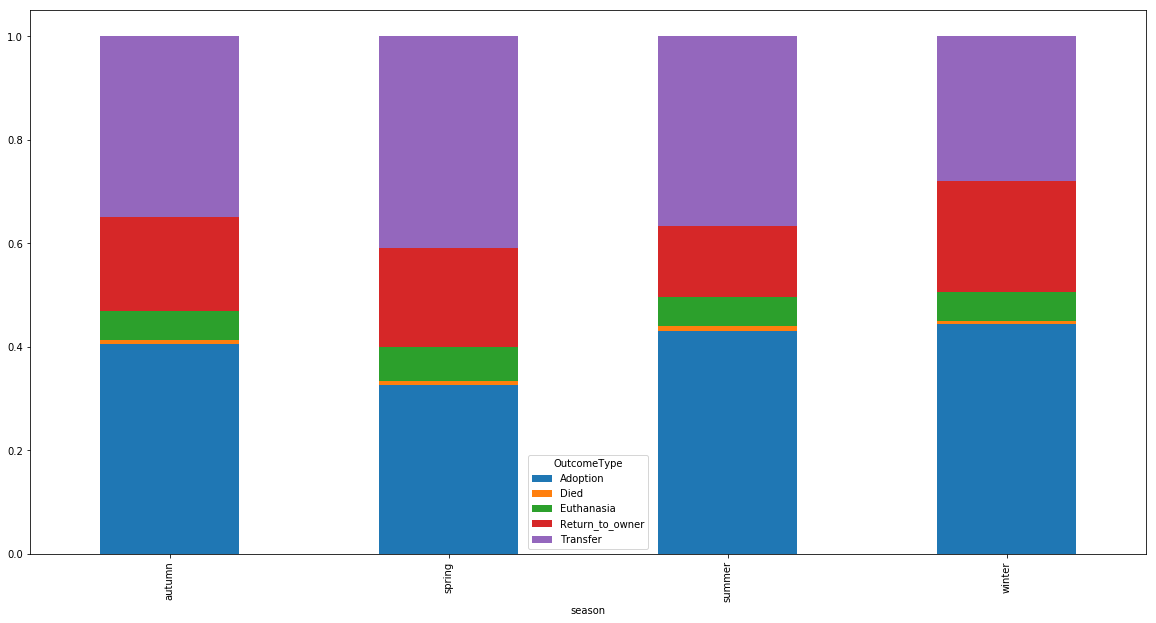

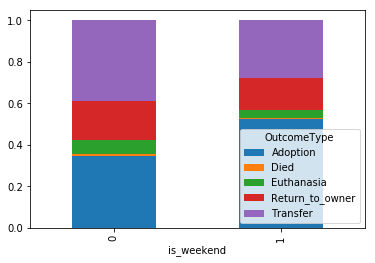

In [226]:
# plot stacked bar chart of season by outcome
season_outcome_df = pd.crosstab(df.season, df.OutcomeType, margins=False)

season_outcome_df.div(season_outcome_df.sum(1).astype(float), axis= 0).plot(kind='bar', stacked=True, figsize=(20,10))

#plt.show()

# plot stacked bar chart of weekday vs weekend
we_outcome_df = pd.crosstab(df.is_weekend, df.OutcomeType, margins=False)
we_outcome_df.div(we_outcome_df.sum(1).astype(float), axis= 0).plot(kind='bar', stacked=True)

plt.show()


In [237]:
pd.crosstab([df.season, df.is_weekend], df.OutcomeType,  margins=True)
#pd.crosstab(df.is_weekend, df.OutcomeType,  margins=True)

OutcomeType        Adoption  Died  Euthanasia  Return_to_owner  Transfer  \
season is_weekend                                                          
autumn 0               1774    41         363             1011      2107   
       1               1373    15          75              403       609   
spring 0               1109    30         291              791      1710   
       1                777    18          83              314       661   
summer 0               1758    46         308              691      1921   
       1               1279    17          90              275       674   
winter 0               1603    19         255              943      1259   
       1               1096    10          86              358       446   
All                   10769   196        1551             4786      9387   

OutcomeType          All  
season is_weekend         
autumn 0            5296  
       1            2475  
spring 0            3931  
       1            1853  
summer 0            4724  
       1            2335  
winter 0            4079  
       1            1996  
All                26689

In [286]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(min_df=0.0025, max_df=0.1, max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                     ngram_range=(1,2), use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words='english')

In [342]:

example_text = list(df.apply(lambda x: '%s %s' % (x['Breed'], x['Color']),axis=1))
example_text = tfv.fit_transform(example_text)
print tfv.get_feature_names()
#print example_text
example_text.shape
weights = np.asarray(example_text.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tfv.get_feature_names(), 'weight':weights})
weights_df.sort_values(by='weight', ascending=False).head(20)
len(tfv.get_feature_names())
print example_text.shape
print type(example_text)

#np.asarray(example_text.mean(axis=0)).reshape(-1).shape

[u'american', u'american bulldog', u'american pit', u'american staffordshire', u'anatol', u'anatol shepherd', u'apso', u'australian', u'australian cattle', u'australian kelpie', u'australian shepherd', u'basset', u'basset hound', u'beagle', u'beagle mix', u'black brindle', u'black brown', u'black mouth', u'black smoke', u'black tan', u'blue', u'blue lacy', u'blue merle', u'blue tabby', u'blue white', u'border', u'border collie', u'border terrier', u'boston', u'boston terrier', u'boxer', u'boxer mix', u'brindle', u'brindle white', u'brown black', u'brown brindle', u'brown merle', u'brown white', u'buff', u'bull', u'bull mix', u'bull terrier', u'bulldog', u'bulldog mix', u'cairn', u'cairn terrier', u'calico', u'cardigan', u'cardigan welsh', u'catahoula', u'catahoula mix', u'cattle', u'cattle dog', u'chihuahua', u'chihuahua longhair', u'chihuahua shorthair', u'chinese', u'chinese sharpei', u'chocolate', u'chocolate white', u'chow', u'chow chow', u'coat', u'cocker', u'cocker spaniel', u'co

In [270]:
from sklearn.decomposition import TruncatedSVD

In [335]:
svd = TruncatedSVD(n_components=100)
svd.fit(example_text)
example_text = svd.transform(example_text)

In [339]:
example_text.shape
example_text[:1,]

array([[  8.52934782e-02,   1.04326828e-02,  -1.80955434e-02,
          5.11113115e-02,  -3.88460802e-02,   1.58041442e-02,
         -1.18141396e-03,  -9.84083634e-03,  -5.61500697e-02,
          1.24986493e-03,   2.54294653e-03,   1.61930289e-02,
          3.41578026e-02,  -2.46795221e-02,  -8.02428735e-03,
         -1.38053375e-01,   4.60334525e-02,  -1.22791597e-01,
         -6.61585617e-02,  -7.41199200e-02,  -2.02905372e-02,
         -1.85709374e-02,   7.68857124e-02,   7.97045125e-01,
          2.97954892e-01,   1.47703252e-01,  -4.06234088e-02,
          9.17087757e-03,  -3.58594689e-02,   6.50135517e-02,
         -3.43976675e-01,   3.72375052e-02,  -9.44332502e-02,
         -7.77530364e-03,   3.06570821e-02,  -7.07680006e-02,
         -3.50544217e-02,  -7.77963800e-02,   3.29057689e-02,
          3.31166841e-02,  -1.82490589e-02,   3.73602274e-02,
          3.31941537e-02,  -2.37953173e-02,   3.07391724e-03,
          1.34625230e-02,   1.51253782e-02,   1.37071413e-02,
        

In [352]:
df.isnull().any()
#features=list(set(list(df.columns))-set(AnimalId)-set(OutcomeType)-set(OutcomeSubtype))
#[ x for x in df.columns]
#col_id = ['AnimalID']
#col_target = ['OutcomeType']
#col_features = ['']

AnimalID          False
Name               True
DateTime          False
OutcomeType       False
OutcomeSubtype     True
AnimalType        False
SexuponOutcome    False
AgeuponOutcome    False
Breed             False
Color             False
has_name          False
is_dog            False
is_operated       False
gender            False
age_label         False
breed_group       False
clean_breed       False
breed_purity      False
is_weekend        False
season            False
dtype: bool